추천 시스템 - 협엄 필터링 Matrix Factorization



In [1]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [7]:
rating_data = pd.read_csv('./data/ratings.csv')
movie_data = pd.read_csv('./data/movies.csv')

In [8]:
rating_data.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [11]:
print(movie_data.shape)
print(rating_data.shape)

(9125, 3)
(100004, 4)


- 두개의 파일은 사용자-평점 데이터와 영화 데이터로 나뉘어져 있음
- 이 두개의 파일은 공통적으로 movieid를가지고 있음. 즉 movieid를 이용하면 하나로 합칠 수 있음

<h2>전처리</h2>

In [12]:

rating_data.drop('timestamp',axis=1, inplace=True)
rating_data.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [13]:

movie_data.drop('genres',axis=1,inplace=True)
movie_data.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [14]:

user_movie_data = pd.merge(rating_data, movie_data, on = 'movieId')
user_movie_data.head()

,userId,movieId,rating,title
0,1,31,2.5,Dangerous Minds (1995)
1,1,1029,3.0,Dumbo (1941)
2,1,1061,3.0,Sleepers (1996)
3,1,1129,2.0,Escape from New York (1981)
4,1,1172,4.0,Cinema Paradiso (Nuovo cinema Paradiso) (1989)


In [15]:
user_movie_data.shape

(100004, 4)

불필요한 칼럼을 제거 -> pandas의 merge를 이용하여 하나로 합침
이제, pivot_table를 만들어줌

- value : rating
- column : movie title
- index : user id

In [17]:

user_movie_rating = user_movie_data.pivot_table('rating',index='userId',columns='title').fillna(0)

In [18]:
user_movie_rating.shape

(671, 9064)

In [19]:
user_movie_rating.head()

title,"""Great Performances"" Cats (1998)",$9.99 (2008),'Hellboy': The Seeds of Creation (2004),'Neath the Arizona Skies (1934),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),...,Zulu (1964),Zulu (2013),[REC] (2007),eXistenZ (1999),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931),İtirazım Var (2014)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


사용자-영화 기준의 데이터를 영화-사용자 기준으로 만들어서 특정 '영화'와 비슷한 영화를 추천해주는 로직을 구현

In [20]:
movie_user_rating = user_movie_rating.values.T
movie_user_rating.shape

(9064, 671)

In [21]:
movie_user_rating

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [22]:
type(movie_user_rating)

numpy.ndarray

1. svd를 사용
- svd(singular value decomposion),특이값 분해 : m x n 크기의 데이터 행렬 A를 아래와 같이 분해하는 것
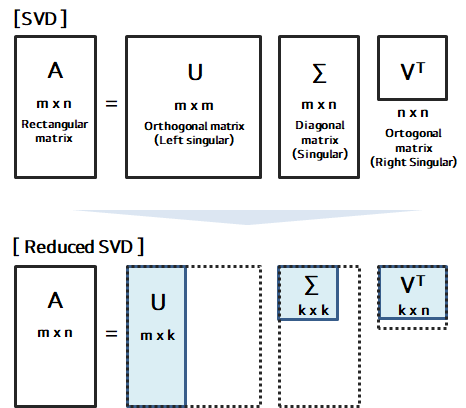
- 출처 : https://m.blog.naver.com/kiakass/222200041769

### 설명

1. 행렬 U와 V에 속한 열벡터는 특이벡터(singular vector)로 불리며, 이 특이벡터들은 서로 직교하는 성질을 가지고 있음
2. 가운데 Σ 기호로 보이는 것은 행렬임
    - 이 행렬은 대각행렬의 성질을 가지고 있음.
    - 대각 성분이 행렬 A의 특이값이고, 나머지 성분은 0.


### 그래서 SVD를 적용하는 이유는 무엇일까?
1. 차원 축소 :
    - 원래 평점 행렬은 매우 커질 수 있고, 많은 값들이 비어져 있음 (평점을 주지 않은 영화가 많기 때문)
    - SVD를 적용하면 "데이터를 작은 잠재 요인"으로 압축해준다. 
    - 이때 중요한 정보를 유지하면서도 불필요한 잡음을 줄일 수 있음
    - 영화에 대한 100개의 질문을 모두 하지 않고도, 그 영화의 액션성이나 감정성 같은 몇가지 중요한 특성만으로도 평점 예측이 가능해짐
2. 사용자와 아이템 간의 숨겨진 관계를 찾기 위해 : 
    - SVD는 사용자와 아이템 간의 잠재적인 관계를 찾는다.

In [25]:
#scikit learn의 Truncated SVD를 사용
SVD = TruncatedSVD(n_components=12)


여기서 왜 n_componets = 12를 사용할까?

In [26]:
matrix = SVD.fit_transform(movie_user_rating)
matrix.shape

(9064, 12)

In [28]:
matrix[0]

array([ 0.01227491, -0.00250751, -0.01554761,  0.03398028,  0.0144199 ,
       -0.00365537,  0.00223093,  0.04487183, -0.01642797, -0.02203545,
       -0.00876574,  0.01090078])

이렇게 나온 데이터를 활용하여 피어슨 상관계수를 구한다

In [29]:
corr = np.corrcoef(matrix)
corr.shape

(9064, 9064)

In [30]:
corr2 = corr[:200,:200]
corr2.shape

(200, 200)

<Axes: >

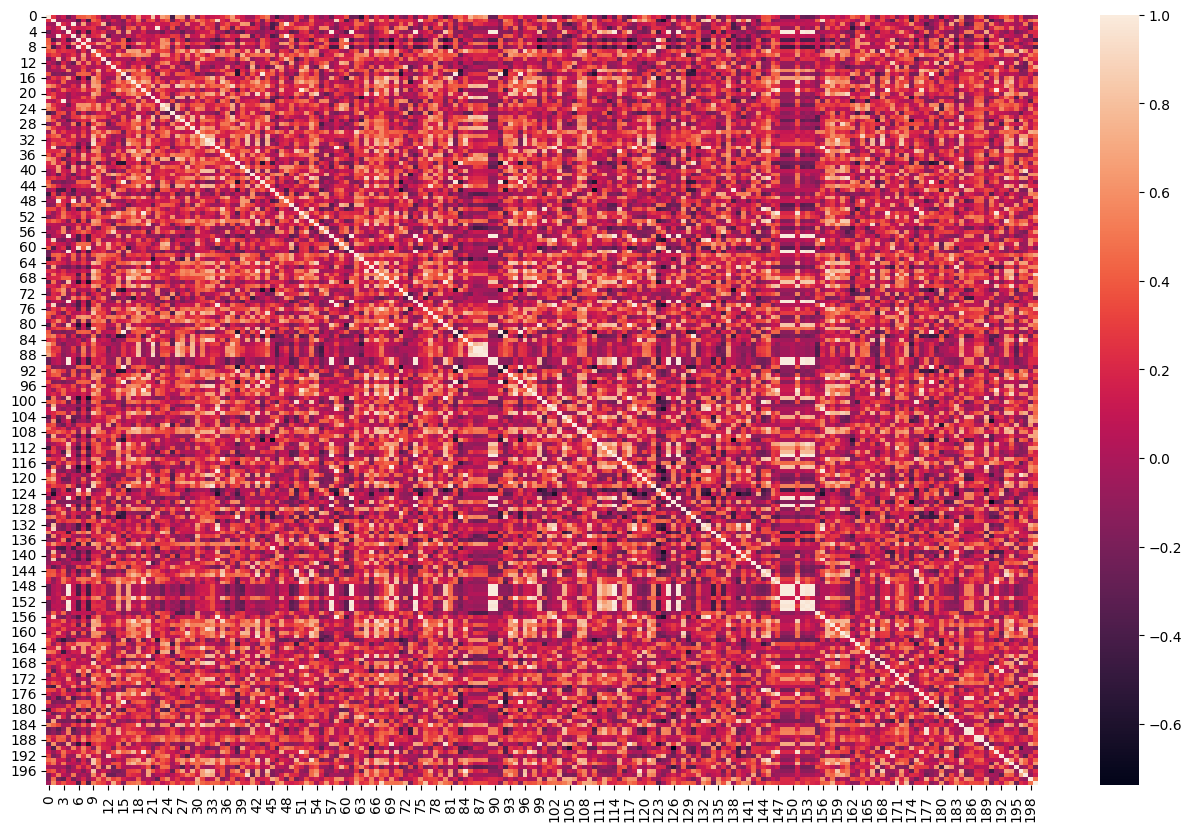

In [31]:
plt.figure(figsize=(16,10))
sns.heatmap(corr2)

상관계수를 이용하여 특정 영화와 상관계수가 높은 영화를 뽑아줌

In [37]:
movie_title = user_movie_rating.columns
movie_title_list = list(movie_title)
coffey_hands = movie_title_list.index("Dangerous Minds (1995)")

In [38]:
corr_coffey_hands = corr[coffey_hands]

In [39]:
list(movie_title[(corr_coffey_hands >= 0.9)])[:50]

['Clear and Present Danger (1994)',
 'Cliffhanger (1993)',
 'Crimson Tide (1995)',
 'Dances with Wolves (1990)',
 'Dangerous Minds (1995)',
 'Die Hard: With a Vengeance (1995)',
 'Firm, The (1993)',
 'First Knight (1995)',
 'Legends of the Fall (1994)',
 'Net, The (1995)',
 'Outbreak (1995)',
 'Philadelphia (1993)',
 'Pretty Woman (1990)',
 'Specialist, The (1994)',
 'Speed (1994)',
 'Tombstone (1993)',
 'Under Siege 2: Dark Territory (1995)',
 'Waterworld (1995)']

Dangerous Minds (1995) 영화를 기준으로 비슷한 영화 출력

## 한 사용자에게 개인 추천

- 위 코드는 하나의 영화에 대해서 비슷한 영화를 추천해주는 것을 적용
- 보통 추천 시스템은 사용자에게 추천을 해주어야 된다.

사용자에게 추천을 해주기 위해서 사용자 맞춤 협업 필터링 행렬 분해를 적용

In [40]:
df_ratings = pd.read_csv('./data/ratings.csv')
df_movies = pd.read_csv('./data/movies.csv')

In [41]:
df_user_movie_ratings = df_ratings.pivot(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)

In [42]:
df_user_movie_ratings

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


1. pivot table을 matrix로 변환
2. np.mean(axis=1)을 통해 각 사용자들이 매기는 평점 평균을 구함
3. 1에서 구한 값과 2에서 구한 값을 빼서 사용자-평균 데이터 값을 변경

In [44]:
# as_matrix() -> pandas 0.23.0 버전에서 사용중단됨
#numpy matrix로 만든것
matrix = df_user_movie_ratings.to_numpy()

In [45]:
matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.]])

In [46]:
# user_ratings_mean은 사용자의 평균 평점
user_ratings_mean =  np.mean(matrix,axis=1)

In [47]:
# R_user_mean : 사용자- 영화에 대해 사용자 평균 평점을 뺀 것.
matrix_user_mean = matrix - user_ratings_mean.reshape(-1,1)

In [49]:
matrix.shape

(671, 9066)

In [50]:
pd.DataFrame(matrix_user_mean, columns= df_user_movie_ratings.columns).head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
0,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,...,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625
1,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,3.970770,...,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230
2,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,...,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075
3,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,3.902162,...,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838
4,-0.043128,-0.043128,3.956872,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,...,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128


1. 사용자 671명이 9066개의 영화에 대해 평점을 매긴 값이 존재
2. 사용자 671명의 각각 평균 평점을 구함
3. 사용자 671명의 9066개의 영화에 대해 평점을 조금 변경 -> 1에서 구한 값 -> 2에서 구한값

In [51]:
# scipy에서 제공해주는 svd.
# U행렬, sigma 행렬, V 전치 행렬을 반환.

U, sigma, Vt = svds(matrix_user_mean, k=12)

In [52]:
print(U.shape)
print(sigma.shape)
print(Vt.shape)

(671, 12)
(12,)
(12, 9066)


현재 이 Sigma 행렬은 0이 아닌 값만 1차원 행렬로 표현된 상태
- 즉, 0이 포함된 대칭행렬로 변환할 때는 Numpy의 diag를 이용해야함

In [53]:
sigma = np.diag(sigma)

In [55]:
sigma.shape

(12, 12)

In [56]:
sigma[0]

array([105.72437051,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ])

In [57]:
sigma[1]

array([  0.        , 110.15522471,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ])

현재 까지 상황을 정리하면 아래와 같습니다.
1. 원본 user-movie 평점 행렬이 있었음
2. 이를 user의 평균 점수를 빼서 matrix_user_mean 이라는 행렬로 만듬
3. 2번의 값을 SVD를 적용해 U, Sigma, Vt 행렬을 구했음
4. Sigma 행렬은 현재 0이 포함이 되지 않은 값으로만 구성되어 있음. 이를 대칭행렬로 변환



In [58]:
# U, Sigma, Vt의 내적을 수행하면, 다시 원본 행렬로 복원이 된다.
# 거기에 + 사용자 평균 rating을 적용한다.w

svd_user_predicted_ratings = np.dot(np.dot(U, sigma),Vt) + user_ratings_mean.reshape(-1,1)

In [59]:
df_svd_preds = pd.DataFrame(svd_user_predicted_ratings, columns = df_user_movie_ratings.columns)
df_svd_preds.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
0,-0.079686,0.021779,-0.013837,-0.005870,-0.028877,0.032371,0.000715,-0.004428,-0.005219,0.038195,...,-0.004324,-0.004352,0.010478,-0.004256,-0.003944,-0.005674,0.018157,-0.005575,-0.005297,-0.003766
1,1.428452,1.608841,0.529476,0.168278,0.520809,1.107473,0.529719,0.089376,0.296270,1.970031,...,0.013227,-0.002275,0.020680,-0.005245,-0.007644,-0.021019,0.031243,-0.000957,-0.000753,0.026901
2,0.977246,0.396971,0.000299,0.027444,0.021287,0.141458,-0.057134,0.031633,-0.012538,0.383576,...,0.002761,0.004907,-0.014190,-0.000251,-0.006007,-0.003189,-0.026916,0.014637,0.013287,-0.005741
3,1.870844,1.169993,0.252202,0.094831,-0.181713,-0.511953,-0.027820,-0.143080,0.013247,1.461694,...,0.026412,-0.027245,0.054681,0.018450,0.034544,-0.035740,0.088889,-0.019365,-0.017113,0.066559
4,1.182777,0.924903,0.075998,0.061505,0.602680,-0.159825,0.339925,0.081534,-0.079666,0.535018,...,-0.029124,-0.029357,0.009064,-0.029092,-0.030890,-0.057453,0.026344,-0.024027,-0.024614,-0.032752


In [60]:
df_svd_preds.shape

(671, 9066)

- 인자를 사용자 아이디, 영화 정보 테이블, 평점 테이블 등을 받음
- 사용자 아이디에 SVD로 나온 결과의 영화 평점이 가장 높은 데이터 순으로 정렬
- 사용자가 본 데이터를 제외
- 사용자가 안 본 영화에서 평점이 높은 것을 추천

### 왜 사용자 평균을 빼고 다시 더핧까?
1. 사용자의 성향을 보정하기 위해 :
    - 각 사용자의 평점 습관이 다름. 어떤 사용자는 대체로 높은 평점을 주고, 어떤 사용자는 낮은 평점을 줄 수 있음.
    - 예를 들어, User1은 모든 영화에 높은 평점을 주는 경향이 있다면, 단순히 그가 준 평점만 보면 그의 취향을 제대로 파악하기 어려움
    - 이때, 평균을 빼줌으로써 그 사람의 절대적인 평점 대신 영화 간의 상대적인 차이를 살피는 것임

In [64]:
def recommend_movies(df_svd_preds, user_id, ori_movies_df, ori_ratings_df, num_recommendations=5):
    
    #현재는 index로 적용이 되어있으므로 user_id - 1을 해야함.
    user_row_number = user_id - 1 
    
    # 최종적으로 만든 pred_df에서 사용자 index에 따라 영화 데이터 정렬 -> 영화 평점이 높은 순으로 정렬 됌
    sorted_user_predictions = df_svd_preds.iloc[user_row_number].sort_values(ascending=False)
    
    # 원본 평점 데이터에서 user id에 해당하는 데이터를 뽑아낸다. 
    user_data = ori_ratings_df[ori_ratings_df.userId == user_id]
    
    # 위에서 뽑은 user_data와 원본 영화 데이터를 합친다. 
    user_history = user_data.merge(ori_movies_df, on = 'movieId').sort_values(['rating'], ascending=False)
    
    # 원본 영화 데이터에서 사용자가 본 영화 데이터를 제외한 데이터를 추출
    recommendations = ori_movies_df[~ori_movies_df['movieId'].isin(user_history['movieId'])]
    # 사용자의 영화 평점이 높은 순으로 정렬된 데이터와 위 recommendations을 합친다. 
    recommendations = recommendations.merge( pd.DataFrame(sorted_user_predictions).reset_index(), on = 'movieId')
    # 컬럼 이름 바꾸고 정렬해서 return
    recommendations = recommendations.rename(columns = {user_row_number: 'Predictions'}).sort_values('Predictions', ascending = False).iloc[:num_recommendations, :]
                      

    return user_history, recommendations

In [65]:
already_rated, predictions = recommend_movies(df_svd_preds, 330, df_movies, df_ratings, 10)

In [67]:
already_rated.head(10)

,userId,movieId,rating,timestamp,title,genres
47,330,1094,5.0,948577200,"Crying Game, The (1992)",Drama|Romance|Thriller
14,330,213,5.0,948577039,Burnt by the Sun (Utomlyonnye solntsem) (1994),Drama
34,330,527,5.0,948577164,Schindler's List (1993),Drama|War
45,330,1035,5.0,948574126,"Sound of Music, The (1965)",Musical|Romance
48,330,1172,5.0,948575236,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama
53,330,1249,5.0,948576522,"Femme Nikita, La (Nikita) (1990)",Action|Crime|Romance|Thriller
27,330,373,5.0,948576522,Red Rock West (1992),Thriller
58,330,1428,5.0,948731410,Angel Baby (1995),Drama
61,330,1575,5.0,948577442,Gabbeh (1996),Drama
67,330,1683,5.0,948578017,"Wings of the Dove, The (1997)",Drama|Romance


In [68]:
predictions

,movieId,title,genres,Predictions
246,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,2.060064
294,356,Forrest Gump (1994),Comedy|Drama|Romance|War,1.772814
497,608,Fargo (1996),Comedy|Crime|Drama|Thriller,1.526111
487,590,Dances with Wolves (1990),Adventure|Drama|Western,1.508960
316,380,True Lies (1994),Action|Adventure|Comedy|Romance|Thriller,1.276646
40,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,1.265219
313,377,Speed (1994),Action|Romance|Thriller,1.142113
214,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,1.076539
295,357,Four Weddings and a Funeral (1994),Comedy|Romance,1.065911
488,592,Batman (1989),Action|Crime|Thriller,1.048861
